In [22]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
class ConfigPP:
    T = 20.0
    T_unit = 0.001
    N = int(T / T_unit)
    U_start = 10.0
    V_start = 5.0
    alpha = 1.0
    beta = 3.0
    gamma = 0.3
    e = 0.333
    ub = T
    lb = 0.0

class SimpleNetworkPP(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkPP, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        self.initial_start()
        self.model_name = "SimpleNetworkPP"
        self.sig = nn.Tanh()
        self.fc1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 100),
            'sig4': self.sig,
            'lin5': nn.Linear(100, 1),
            # 'sig5': self.sig,
        }))

        self.fc2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 100),
            'sig4': self.sig,
            'lin5': nn.Linear(100, 1),
            # 'sig5': self.sig,
        }))

    def forward(self, inputs):
        u_old, v_old = torch.chunk(inputs, 2, 1)
        u_new = self.fc1(u_old)
        v_new = self.fc2(v_old)
        outputs = torch.cat((u_new, v_new), 1)
        return outputs

    def generate_x(self):
        # lb_row = np.repeat(self.config.lb, 2).reshape([1, -1])
        # ub_row = np.repeat(self.config.ub, 2).reshape([1, -1])
        # x = lb_row + (ub_row - lb_row) * lhs(1, self.config.N)
        # x = sorted(x, key=lambda xx: xx[0])
        x = [[i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        # self.y0 = torch.Tensor(np.asarray([0.0, 0.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.U_start, self.config.V_start]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        y = self.decode_y(self.forward(self.x))
        # print("y.shape:", y[:, 0:1].shape)
        # print(y[:, 0:1])
        # print("self.x.shape:", self.x[:, 0:1].shape)
        # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
        u = y[:, 0:1]
        v = y[:, 1:2]

        u_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
        v_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
        u_t = u_t.reshape([self.config.N, 1])
        v_t = v_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_u = u_t - (self.config.alpha - self.config.gamma * v) * u  # nn model
        f_v = v_t - (-self.config.beta + self.config.e * self.config.gamma * u) * v  # nn model
        # f_u = u_t - torch.cos(self.decode_t(self.x)[:, 0:1])
        # f_v = v_t - torch.cos(self.decode_t(self.x)[:, 1:2])
        f_y = torch.cat((f_u, f_v), 1)
        y0_pred = self.decode_y(self.forward(self.encode_y(self.t0)))
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.encode_y(self.t0)=", self.encode_y(self.t0), "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        # loss_3 = torch.mean(torch.square(1/(u*u+v*v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        loss = loss_1 + loss_2
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])

        return loss, [loss_1, loss_2]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)

    def encode_y(self, num):
        return num
        # return (num - self.config.y_lb) / (self.config.y_ub - self.config.y_lb) * 2.0 - 1.0

    def decode_y(self, num):
        return num
        # return self.config.y_lb + (num + 1.0) / 2.0 * (self.config.y_ub - self.config.y_lb)

    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [26]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def train_pp(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    epoch_step = args.epoch_step
    start_time = time.time()
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, = loss_list[0], loss_list[1]
        loss.backward()
        optimizer.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Time:{5:.6f}s".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), time.time() - start_time))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_pp(model, args, config, now_string, True)


def test_pp(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    u, v = torch.chunk(y, 2, 1)
    # print("u=", u)
    # print("v=", v)
    u = model.decode_y(u)
    v = model.decode_y(v)
    u = [item[0] for item in u.cpu().detach().numpy()]
    v = [item[0] for item in v.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[uu, vv, xx] for uu, vv, xx in zip(u, v, x)]
    pairs.sort(key=lambda xx: xx[2])
    u = [item[0] for item in pairs]
    v = [item[1] for item in pairs]
    x = [item[2] for item in pairs]
    print("u=", u[:10], "...", u[-10:])
    print("v=", v[:10], "...", v[-10:])
    print("x=", x[:10], "...", x[-10:])
    plt.plot(x, u, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, v, marker='.', markersize=0.2, linewidth=0.1, c="r")
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_{int(time.time())}.png"
    plt.savefig(figure_save_path, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path))

class Args:
  epoch = 2000
  epoch_step = 100
  lr = 0.01
  main_path = "."
  save_step = 500

def run_pp(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=10, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigPP
    model = SimpleNetworkPP(config).to(device)
    train_pp(model, args, config, now_string)
    model = SimpleNetworkPP(config).to(device)
    test_pp(model, args, config, now_string)

using cuda
epoch = 2000
epoch_step = 100
model_name = SimpleNetworkPP
now_string = 2022-03-26-21-47-16
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_best.pt
Epoch [00100/02000] Loss:1.859861 Loss_1:0.055471 Loss_2:1.804390 Time:0.787517s
Epoch [00200/02000] Loss:1.817640 Loss_1:0.069691 Loss_2:1.747949 Time:0.789119s
Epoch [00300/02000] Loss:1.840737 Loss_1:0.155629 Loss_2:1.685109 Time:0.788149s
Epoch [00400/02000] Loss:2.068299 Loss_1:0.166862 Loss_2:1.901436 Time:0.788551s
Epoch [00500/02000] Loss:1.843436 Loss_1:0.140265 Loss_2:1.703171 Time:0.805954s
Testing & drawing...
u= [9.604859, 9.595697, 9.586506, 9.577274, 9.568009, 9.558712, 9.549388, 9.540027, 9.530637, 9.521224] ... [-0.0038727075, -0.0038702637, -0.0038676113, -0.0038651973, -0.003862813, 

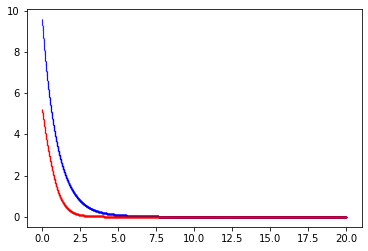

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_1648331240.png
Epoch [00600/02000] Loss:1.903663 Loss_1:0.001489 Loss_2:1.902175 Time:1.261616s
Epoch [00700/02000] Loss:1.866180 Loss_1:0.008637 Loss_2:1.857543 Time:0.787845s
Epoch [00800/02000] Loss:1.813426 Loss_1:0.067862 Loss_2:1.745564 Time:0.790251s
Epoch [00900/02000] Loss:1.822080 Loss_1:0.116708 Loss_2:1.705372 Time:0.796810s
Epoch [01000/02000] Loss:1.871987 Loss_1:0.008958 Loss_2:1.863029 Time:0.788618s
Testing & drawing...
u= [9.541445, 9.531484, 9.5215, 9.511483, 9.501441, 9.491373, 9.481289, 9.471178, 9.461048, 9.450905] ... [0.0041181296, 0.004120961, 0.004123792, 0.004126683, 0.004129544, 0.0041323155, 0.0041351765, 0.004137978, 0.004140869, 0.0041436106]
v= [5.408408, 5.404128, 5.3998294, 5.3955054, 5.3911586, 5.3867893, 5.3824015, 5.3779893, 5.373555, 5.3691025] ... [0.008458424, 0.008458499, 0.008458611, 0.00845864, 0.008458775, 0.00845886, 0.0

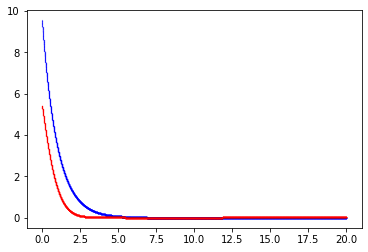

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_1648331245.png
Epoch [01100/02000] Loss:2.037345 Loss_1:0.097784 Loss_2:1.939561 Time:1.682022s
Epoch [01200/02000] Loss:1.932710 Loss_1:0.161203 Loss_2:1.771507 Time:0.970710s
Epoch [01300/02000] Loss:1.834795 Loss_1:0.020113 Loss_2:1.814682 Time:0.787667s
Epoch [01400/02000] Loss:1.812968 Loss_1:0.066431 Loss_2:1.746537 Time:0.808169s
Epoch [01500/02000] Loss:1.817592 Loss_1:0.102496 Loss_2:1.715096 Time:0.788475s
Testing & drawing...
u= [9.796386, 9.787461, 9.778461, 9.769376, 9.760208, 9.750964, 9.741649, 9.732252, 9.722782, 9.713245] ... [0.0028544664, 0.0028548837, 0.0028555393, 0.0028560758, 0.002856493, 0.002857089, 0.0028576255, 0.002858162, 0.0028588772, 0.0028591752]
v= [5.2284594, 5.223173, 5.2178845, 5.2125874, 5.2072835, 5.201976, 5.1966662, 5.1913486, 5.1860275, 5.180705] ... [-0.0019486584, -0.0019486584, -0.0019486435, -0.001948569, -0.0019486137, 

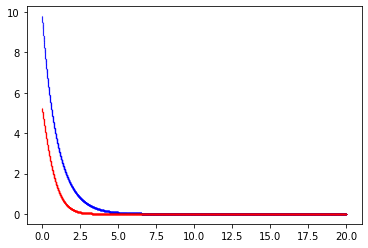

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_1648331250.png
Epoch [01600/02000] Loss:1.814375 Loss_1:0.085107 Loss_2:1.729267 Time:1.257316s
Epoch [01700/02000] Loss:1.818072 Loss_1:0.042951 Loss_2:1.775121 Time:0.787708s
Epoch [01800/02000] Loss:1.815214 Loss_1:0.082622 Loss_2:1.732592 Time:0.788355s
Epoch [01900/02000] Loss:1.816250 Loss_1:0.082378 Loss_2:1.733872 Time:0.789508s
Epoch [02000/02000] Loss:2.020706 Loss_1:0.265023 Loss_2:1.755683 Time:0.787713s
Testing & drawing...
u= [10.166796, 10.164727, 10.162603, 10.160417, 10.158171, 10.15586, 10.153486, 10.151044, 10.148532, 10.145954] ... [-0.041844085, -0.041844144, -0.041844144, -0.041844144, -0.041844144, -0.041844383, -0.041844323, -0.041844383, -0.041844502, -0.041844383]
v= [4.827259, 4.8229427, 4.8186126, 4.8142614, 4.8098936, 4.8055086, 4.8011093, 4.796691, 4.792256, 4.7878065] ... [0.054367077, 0.054367077, 0.054366868, 0.054366898, 0.05436686

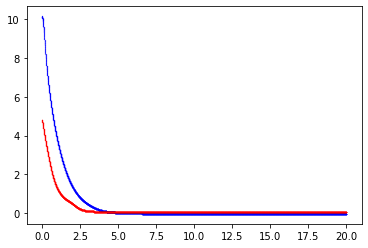

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_1648331254.png
Testing & drawing...
u= [10.166796, 10.164727, 10.162603, 10.160417, 10.158171, 10.15586, 10.153486, 10.151044, 10.148532, 10.145954] ... [-0.041844085, -0.041844144, -0.041844144, -0.041844144, -0.041844144, -0.041844383, -0.041844323, -0.041844383, -0.041844502, -0.041844383]
v= [4.827259, 4.8229427, 4.8186126, 4.8142614, 4.8098936, 4.8055086, 4.8011093, 4.796691, 4.792256, 4.7878065] ... [0.054367077, 0.054367077, 0.054366868, 0.054366898, 0.054366868, 0.054366913, 0.054366853, 0.054366674, 0.054366793, 0.054366704]
x= [0.0, 0.0010001659, 0.0019997358, 0.0029999018, 0.0040000677, 0.0050002337, 0.0059998035, 0.0069999695, 0.008000135, 0.008999705] ... [19.990002, 19.991, 19.992, 19.993, 19.994, 19.995, 19.995998, 19.997002, 19.998, 19.999]


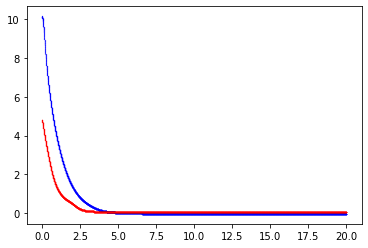

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_2000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-21-47-16_1648331255.png


<Figure size 432x288 with 0 Axes>

In [27]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)